In [1]:
!pip install distance
!pip install fuzzywuzzy
import os
import re
import distance
import numpy as np 
import pandas as pd 
import seaborn as sns
from tqdm import tqdm
from sklearn import svm
from fuzzywuzzy import fuzz
from sklearn import metrics
from bs4 import BeautifulSoup
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.display import Image
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.metrics import log_loss
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 22.2.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip
DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 22.2.2 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\Users\aksha\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
path = "C:/Users/aksha/Downloads/7610 Final"
train = pd.read_csv(path+"/train.csv")
print("Total samples:",len(train))
train.head(10)

Total samples: 404290


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


### Is data imbalanced ?

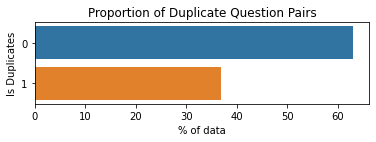

In [3]:
fig= plt.figure(figsize=(6,1.5))
sns.barplot(x=100*train['is_duplicate'].value_counts()/len(train),
            y=(100*train['is_duplicate'].value_counts()/len(train)).index,orient='h',).set(ylabel="Is Duplicates",xlabel="% of data",title="Proportion of Duplicate Question Pairs")
plt.show()

### Checking Missing Values

In [4]:
train.isna().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [5]:
ques2_list = train.loc[train['question1'].isnull(),'question2'].values
ques1_list = train.loc[train['question2'].isnull(),'question1'].values
display(train[train['question1'].isin(ques1_list)])
display(train.loc[train['qid2']==174364,:])

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
263095,263095,174363,239239,How can I develop android app?,What is the best way of creating Android apps?...,0


,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


In [6]:
display(train[train['question2'].isin(ques2_list)])
display(train.loc[train['qid1']==493340,:])

,id,qid1,qid2,question1,question2,is_duplicate
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


,id,qid1,qid2,question1,question2,is_duplicate
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [7]:
df = train.loc[~train.isnull().any(axis=1),:].copy()
print("Any Rows with Missing Data: ",(df.isna().sum()>0).any())
df['question1'] = df.loc[:,'question1'].apply(lambda x: str(x).strip())
df['question2'] = df.loc[:,'question2'].apply(lambda x: str(x).strip())

Any Rows with Missing Data:  False


### Check number of unique questions and duplicates in whole corpus

In [8]:
questions_list = pd.concat([df['question1'] , df['question2']] )
unique_quesList = questions_list.value_counts()[questions_list.value_counts()==1].index
duplicate_quesList = questions_list.value_counts()[questions_list.value_counts()>1].index
print("Number of Questions which are unique: ",len(unique_quesList))
print("Number of Questions which are repeated: ",len(duplicate_quesList))
print("Total number of unique questions in dataset: ",len(questions_list.value_counts()))

Number of Questions which are unique:  425464
Number of Questions which are repeated:  111873
Total number of unique questions in dataset:  537337


### Distribution of repeated questions

In [9]:
rep_ques = questions_list.value_counts()[questions_list.value_counts()>1]
rep_ques

What are the best ways to lose weight?                                                    161
How can you look at someone's private Instagram account without following them?           120
How can I lose weight quickly?                                                            111
What's the easiest way to make money online?                                               88
Can you see who views your Instagram?                                                      79
                                                                                         ... 
How do I get girls to see me sexually?                                                      2
Why doesn't IndiGo airlines have a loyalty/frequent flyer program like other airlines?      2
How do I calculate resistance?                                                              2
Can we use non Tata sky dish antenna for Tata Sky set top box?                              2
Is cat worth a 1 year drop?                                 

Maximum number of times a single question is repeated:  161



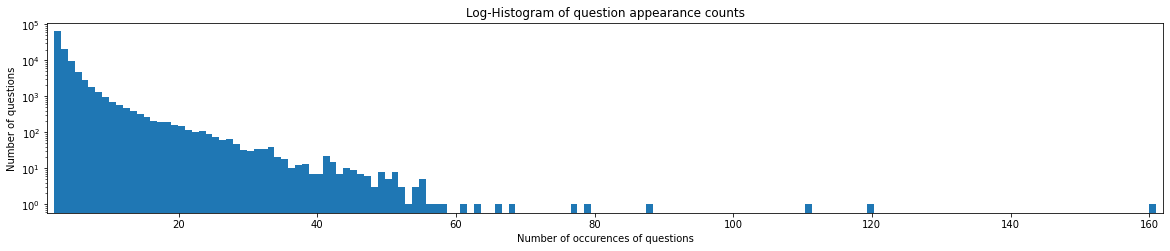

In [10]:
plt.figure(figsize=(20, 3.5))
plt.hist(rep_ques, bins=160)
plt.yscale('log')
plt.xlim((1,162))
plt.title('Log-Histogram of question appearance counts')
plt.xlabel("Number of occurences of questions")
plt.ylabel("Number of questions")
print('Maximum number of times a single question is repeated:  {}\n'.format(max(rep_ques)))
plt.show()

In [11]:
document_corpus = list(set(list(df['question1']) + list(df['question2'])))
math_q = [q  for q in document_corpus if '[math]' in q]

print("Percentage of Questions with '?' (not necessarily ending with): {0:.3f} %".format(100*len([q  for q in document_corpus if '?' in q])/len(document_corpus)))
print("Percentage of Questions not having '?': {0:.3f} %".format(100*len([q  for q in document_corpus if '?' not in q])/len(document_corpus)))
print("Number of Math based questions:  {0:3f} %".format(100*len(math_q)/len(document_corpus)))
print("Questions with multiple parts: {0:.3f} %".format(100*len([ q for q in document_corpus if len(q.split('?'))>2 ])/len(document_corpus) ))
print("\nExamples of Questions with subparts : ",[ q for q in document_corpus if len(q.split('?'))>2 ][0:2]) 
print("\nPersonal or Opinion-based questions: {0:.3f} %".format(100*len([q for q in document_corpus if ('you' in q) or (' i ' in q) ])/len(document_corpus)))
print("\nSome Personal Or Opinion-based questions: ", [q for q in document_corpus if 'you' in q][:2])

Percentage of Questions with '?' (not necessarily ending with): 99.864 %
Percentage of Questions not having '?': 0.136 %
Number of Math based questions:  0.138647 %
Questions with multiple parts: 5.542 %

Examples of Questions with subparts :  ['If I have 50 lakh as black money, what will happen if I disclose it and deposit the money in the bank? After Modi has banned 500/1000 notes in India?', 'How long can a gout attack last? Can the pain get better then get worse again? Would this be the same gout attack?']

Personal or Opinion-based questions: 12.038 %

Some Personal Or Opinion-based questions:  ['What have been the best Halloween costumes you have seen or worn?', 'What would happen if a valet driver crashed your car?']


### Text Pre-processing

In [12]:
def preprocess(q):
    
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q

In [13]:
df['question1'] = df['question1'].apply(preprocess)
df['question2'] = df['question2'].apply(preprocess)
print("Train Data Text Pre-processing Done!")

C:\Users\aksha\anaconda3\lib\site-packages\bs4\__init__.py:337: MarkupResemblesLocatorWarning: "." looks like a directory name, not markup. You may want to open a file found in this directory and pass the filehandle into Beautiful Soup.
  warnings.warn(


Train Data Text Pre-processing Done!


### Clustering Questions

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [10:06<00:00, 33.71s/it]


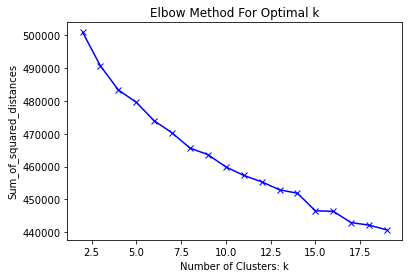

Finding Optimal Cluster Number Done!


<Figure size 432x288 with 0 Axes>

In [14]:
document_corpus = list( set(list(df['question1']) + list(df['question2'])) )
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,2))
x = vectorizer.fit_transform(document_corpus)

Sum_of_squared_distances = []
for k in tqdm(range(2,20)):
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(x)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(range(2,20), Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters: k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()
print("Finding Optimal Cluster Number Done!")
plt.savefig("cluster_analysis.png")

standardised


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [08:40<00:00, 65.02s/it]


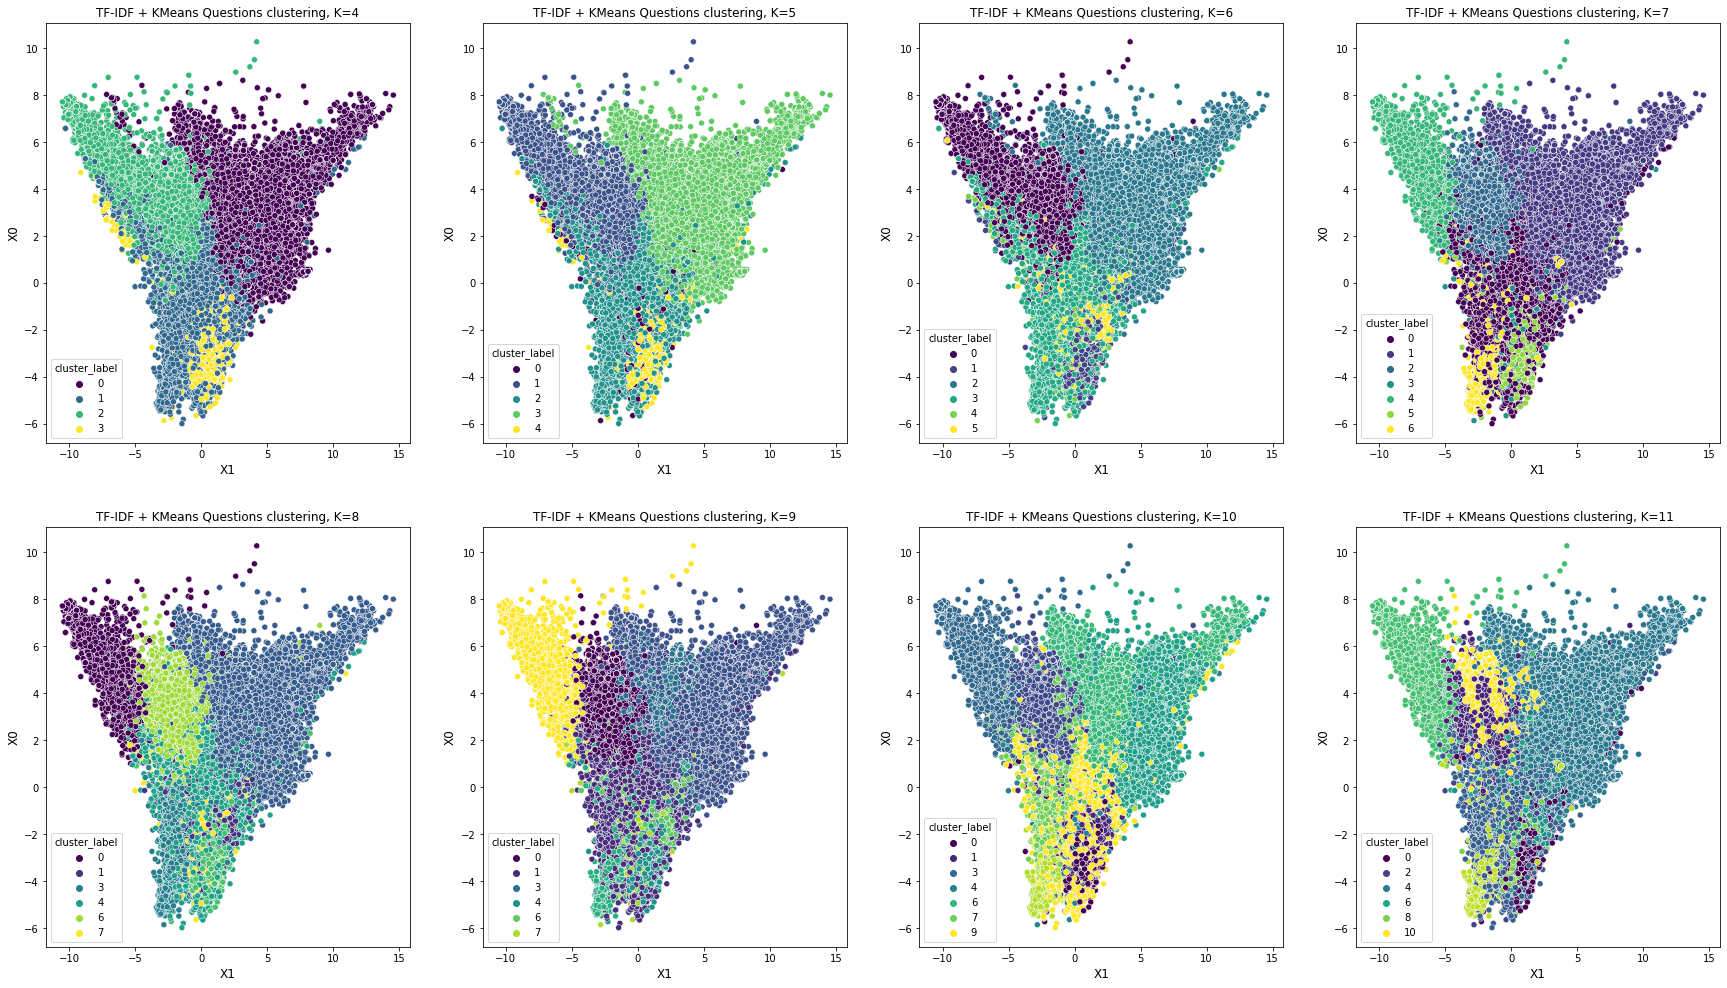

In [17]:
from sklearn.preprocessing import StandardScaler
document_corpus = list(set(list(df['question1']) + list(df['question2'])))
questions_cluster = pd.DataFrame({'questions':document_corpus, 'cluster_label':None})
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,2))
x = vectorizer.fit_transform(questions_cluster['questions'].values)
sc_x = StandardScaler()
std_x = sc_x.fit_transform(x.toarray())
print("standardised")
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30,17))
i=1
for k in tqdm(range(4,12)):
    km = KMeans(n_clusters=k, max_iter=500, n_init=20)
    km = km.fit(x)
    questions_cluster['cluster_label'] = km.labels_
    pca = PCA(n_components=2, random_state=42)
    pca_vecs = pca.fit_transform(std_x)
    x0 = pca_vecs[:, 0]
    x1 = pca_vecs[:, 1]
    questions_cluster['x0']=x0
    questions_cluster['x1']=x1
    plt.subplot(2,4,i)
    plt.title("TF-IDF + KMeans Questions clustering, K="+str(k), fontdict={"fontsize": 12})
    plt.xlabel("X1", fontdict={"fontsize": 12})
    plt.ylabel("X0", fontdict={"fontsize": 12})
    sns.scatterplot(data=questions_cluster, x='x1', y='x0', hue='cluster_label', palette="viridis")
    i+=1
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.03it/s]


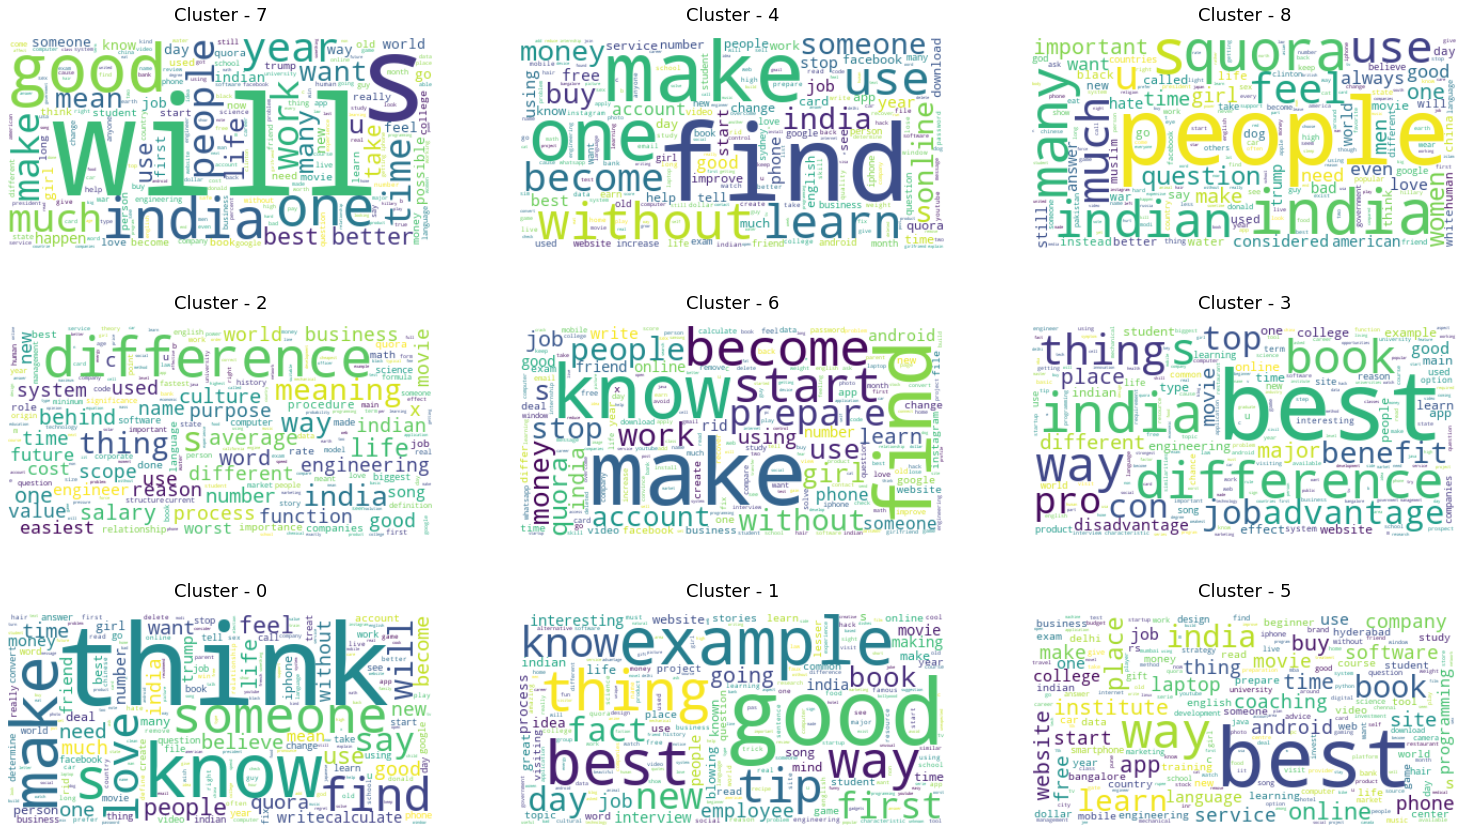

In [18]:
document_corpus = list(set(list(df['question1']) + list(df['question2'])))
questions_cluster = pd.DataFrame({'questions':document_corpus, 'cluster_label':None})
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,4))
x = vectorizer.fit_transform(questions_cluster['questions'].values)
km = KMeans(n_clusters=9, max_iter=500, n_init=30)
km = km.fit(x)
questions_cluster['cluster_label'] = km.labels_


fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(26,15))
i=1
for cluster in tqdm(questions_cluster['cluster_label'].unique()):
    questions = " ".join(questions_cluster[questions_cluster['cluster_label']==cluster]['questions'].values)
    word_cloud = WordCloud(collocations = False, background_color = 'white').generate(questions)
    plt.subplot(3,3,i)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.title("Cluster - "+str(cluster), fontsize=18,pad=17)
    plt.axis("off")
    i+=1
    
#fig.delaxes(axes.flatten()[5])
plt.show()